# Exploring UKCP-18 

## Retriving data with CEDA:

* __Please see 03_aircraft_data.pynb for instructions on ceda certificates. The valid CEDA certificate must be linked to in the specfied environment file below__

## Overview


* Using [Iris](https://scitools-iris.readthedocs.io/en/stable/) to explore UKCP data 


## Prerequisites 
To successfully navigate this notebook, you should be accustom with:
* Basics of python programming:
    * loading modules 
    * variable assignment 
    * basic plotting packages (`Matplotlib.pyplot`)
* Have a basic understanding of weather and climate, for example:
    * Latitude is North-South
    * Longitude is East-West
* Not a full requirement but you may find this notebook useful after or alongside other notebooks in the tutorial

## Learning outcomes

* Calulate useful statistics from Climate data
* Make simple summary plots for example:
    * Time series 
    * BoxPlots 
    
## BackGround 

* UKCP ([UK Climate Projections](https://www.metoffice.gov.uk/research/approach/collaboration/ukcp/about)) provides probabilistic projections over land and a set of high-resolution spatially-coherent future climate projections for the globe at 60km scale, also over the UK at:
    * 12km scale 
    * 2.2km scale - a level previously only used for short-term weather forecasts
    
* [Iris](https://scitools-iris.readthedocs.io/en/stable/) is a Python module, produced by the Met Office to allow easy access to Geospatial Data 
* Iris functions well with well known modules like `Matplotlib` and `Numpy`
* Iris stores data in Cubes- representing the dimensions of the earth:
    * Latitude
    * Longitude
    * Time
* These cubes can be analysed in different dimensions to extract relevant information


First lets import the modules we will be using



In [1]:
import iris
import numpy as np
import pandas as pd
import iris.quickplot as qplt
import iris.plot as iplt
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import requests

In [2]:
# notebook settings
env_file_path = ".env"

HIDE_SECRET_OUTPUT = True

path_to_save_data = './data/UKCP'

For this notebook, a .env file is defined in order to abstract away keys personal to the user. The .env file is kept in the same directory as this notebook. Here is an example of what the .env file looks like:

```
ATMOSPHERIC_CLIENT_ID=xxxxxxxxxxxxxxxxxxxxxx
ATMOSPHERIC_CLIENT_SECRET=xxxxxxxxxxxxxxxxxxxxxx
SOME_OTHER_ENV_VAR=2gt2t1t2t7224pZ/*321
```

As shown, the format for each variable is ENV_VAR_NAME=ENV_SECRET with no spaces between the '=' and the definitions, or at the beginning of a line. A newline is required between each environment variable.
<br>Due to how the file is read without a the common tool `dotenv`, the .env file expects no comments, nor an in-file informational header. The names of each variable should be obvious.
<br>
<br>A __template file for .env__ is given in the repository called `.env_template`. after filling in the template with the users own information, either rename the file itself, or the path to the file in the setting variable above (env_file_path)

In [3]:
# read environment file
env_vars = {}

with open(env_file_path) as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [4]:
# load environment variables
CERT_SECRET = env_vars["CEDA_CERTIFICATE_DIRECTORY"]

In [5]:
links_to_data = [
    'https://dap.ceda.ac.uk/badc/ukcp18/data/land-cpm/uk/2.2km/rcp85/01/tas/day/v20210615/tas_rcp85_land-cpm_uk_2.2km_01_day_19811201-19821130.nc'
]
paths_to_data = []

for link in links_to_data:
    nc_file_name = link.split("/")[-1]
    file_save_path = path_to_save_data + '/' + nc_file_name
    
    paths_to_data.append(file_save_path)
    if not os.path.exists(
        file_save_path
    ):  # don't download files if already exist on disk
        response = requests.get(link, cert=(CERT_SECRET))
        response_content = response.content
        if response.status_code != 200:
            print(response_content)
            print(
                "\n!!!Exception, likely the certificate is not valid! response above!!!\n"
            )
            raise Exception()
        with open(file_save_path, "wb") as f:
            f.write(response_content)

# print(paths_to_data)

Now lets define our filename and load he data into an iris cube using `iris.load_cube()`

* `iris.load_cube` works when you are only expecting one cube from a file, so loads directly to a cube instead of a cube list

In [6]:
filename = paths_to_data[0]

In [7]:
cube = iris.load_cube(filename)

/var/tmp/ipykernel_52978/1749196290.py:1: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cube = iris.load_cube(filename)


Print our cube and read our metadata

In [8]:
cube

Air Temperature (degC),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


#### Looking at the printout of our cube:

* ensemble member 1 
* 360 timestamps
* latitude and longitudes

#### Lets plot a map

* Lets quickly plot a map of our data
* Since we have an ensemble member in our data, we need to index this and time

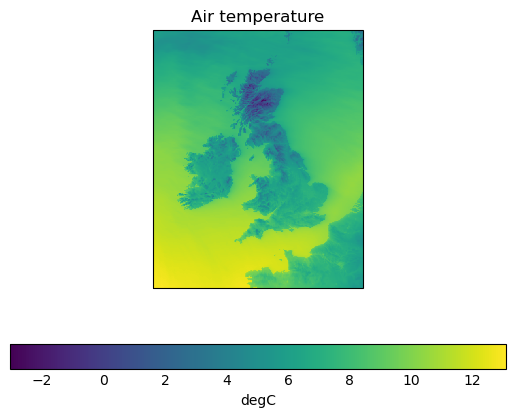

In [9]:
qplt.pcolormesh(cube[0,0,:,:])

#### Have a look at the time cooridnate

In [10]:
print(cube.coord('time').cell(0))
print(cube.coord('time').cell(-1))

Cell(point=cftime.Datetime360Day(1981, 12, 1, 12, 0, 0, 0, has_year_zero=True), bound=(cftime.Datetime360Day(1981, 12, 1, 0, 0, 0, 0, has_year_zero=True), cftime.Datetime360Day(1981, 12, 2, 0, 0, 0, 0, has_year_zero=True)))
Cell(point=cftime.Datetime360Day(1982, 11, 30, 12, 0, 0, 0, has_year_zero=True), bound=(cftime.Datetime360Day(1982, 11, 30, 0, 0, 0, 0, has_year_zero=True), cftime.Datetime360Day(1982, 12, 1, 0, 0, 0, 0, has_year_zero=True)))


### Plotting the mean and standard deviation over time

* collapsed can be used to collapse a cube over certain coordinates
* collapsing latitude and longitude by taking the mean of their value gives us a time series of means

In [11]:
mean = cube.collapsed((['grid_latitude', 'grid_longitude']), iris.analysis.MEAN)
std = cube.collapsed((['grid_latitude', 'grid_longitude']), iris.analysis.STD_DEV)

/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/cube.py:3769: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2217: User

In [12]:
cube_data = cube.core_data()

In [13]:
cube_data_masked = cube_data.compute()

In [14]:
num_of_masked = np.ma.count_masked(cube_data_masked)
print("Number of masked values after computation:", num_of_masked)
assert num_of_masked == 0
# unmask
cube_data_realized = np.ma.filled(cube_data_masked, np.nan).squeeze()
print("Shape of result:", cube_data_realized.shape)

Number of masked values after computation: 0
Shape of result: (360, 606, 484)


In [15]:
mean = np.mean(cube_data_realized, axis=(1,2))
std = np.std(cube_data_realized, axis=(1,2))

* check what units we are using

In [16]:
cube.metadata.units

Unit('degC')

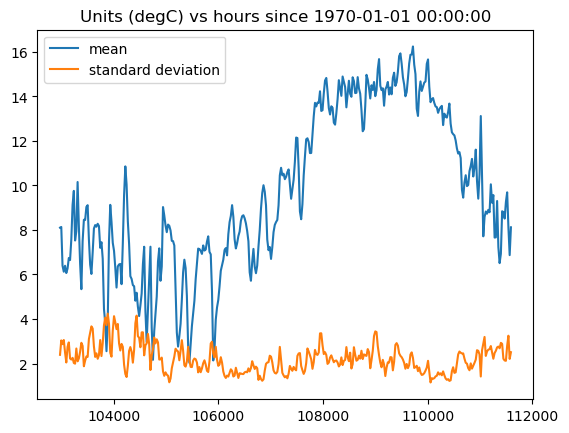

In [17]:
x_axis = cube.coord('time').points
x_axis_name = str(cube.coord('time').units)
plt.plot(x_axis, mean, label='mean')
plt.plot(x_axis, std, label='standard deviation')
plt.title(f'Units (degC) vs {x_axis_name}')
plt.legend()
plt.show()

### Area weighted collapse 

since grid_latitude and grid_longitude boxes are not equal in size, we can take a area weighted mean, which takes into account the size of the grid box. Here's how you do it

In [18]:
import iris.analysis.cartography

In [19]:
try:
    grid_areas = iris.analysis.cartography.area_weights(cube)
except ValueError as e:
    print("EXCEPTION:", e)

EXCEPTION: Calling `_get_lon_lat_coords` with multiple lat or lon coords is currently disallowed


* looks like the latitude and longitude scalar coordinates could be stopping this
* lets try remove them first

In [20]:
cube.remove_coord('latitude')
cube.remove_coord('longitude')

In [21]:
cube

Air Temperature (degC),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [22]:
grid_areas = iris.analysis.cartography.area_weights(cube)

* great that worked! 
* for the command above to work both `grid_latitude` and `grid_longitude` need to have bounds 
* if you find a situation where a cube doesn't have bounds, you  can run a command to guess them 
* for example 

`cube.coord('grid_latitude').guess_bounds()`

`cube.coord('grid_longitude').guess_bounds()`

* now lets calculate our weighted mean

In [23]:
mean_weighted = cube.collapsed((['grid_latitude', 'grid_longitude']), iris.analysis.MEAN, weights=grid_areas)

* lets compare mean and mean_weighted

In [24]:
mean_weighted = mean_weighted[0].data
num_of_masked = np.ma.count_masked(mean_weighted)
assert num_of_masked == 0
# unmask
mean_weighted = np.ma.filled(mean_weighted, np.nan).squeeze()

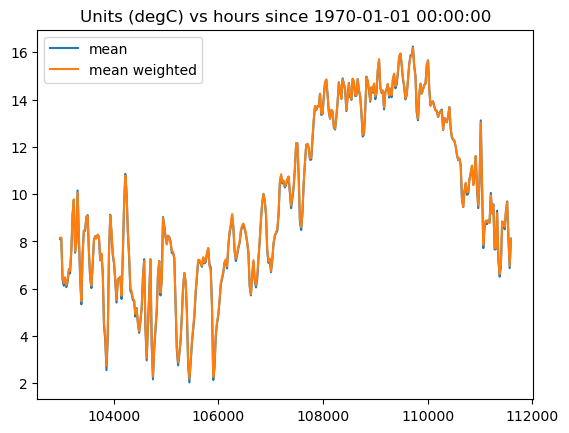

In [25]:
plt.plot(x_axis, mean, label='mean')
plt.plot(x_axis, mean_weighted, label='mean weighted')
plt.title(f'Units (degC) vs {x_axis_name}')
plt.legend()
plt.show()

Can see a slight difference with the blue under the orange

### Summary of statistics

* None of this cubes data is masked, we can see this by printing `cube.data.mask`
* To get the data out we only need to do a `.data.data`
* Can then put into a pandas dataframe and get a summary of statistics

In [26]:
cube.data.mask

False

In [27]:
data = cube.data.data

In [28]:
data.shape

(1, 360, 606, 484)

In [29]:
df = pd.DataFrame(data.ravel(),columns = ['air_temp_values'])
df.describe()

,air_temp_values
count,1.055894e+08
mean,9.704495e+00
std,4.249174e+00
min,-1.848618e+01
25%,6.733057e+00
50%,9.660303e+00
75%,1.286660e+01
max,2.889956e+01


* The way above easy enough and works well
* However if we have to much data we will get memory issues
* Here's a function to return a summary of statistics collapsing with iris
* this should keep data lazy and not load into memory

    
 

In [30]:
def iris_describe(cube,weights=None):
    
    coords = [coord.name() for coord in cube.dim_coords]
    count = cube.collapsed((coords), iris.analysis.COUNT,function=lambda values: values != np.NaN)
    mean = cube.collapsed((coords), iris.analysis.MEAN,weights=weights)
    std = cube.collapsed((coords), iris.analysis.STD_DEV)
    mini = cube.collapsed((coords), iris.analysis.MIN)
    maxi = cube.collapsed((coords), iris.analysis.MAX)
    
    dictionary = {
        'count':count.data,
        'mean': mean.data,
        'std':std.data,
        'min':mini.data,
        'max':maxi.data,
    }
    
    return dictionary


In [31]:
dictonary = iris_describe(cube)

/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/large/lib/python3.10/site

#### Print the dictonary values we collected 

* We can see a summary of the statistics we collected here
* Have a go at changing/ writing a new function that uses different statistics, click [here](https://scitools-iris.readthedocs.io/en/stable/generated/api/iris/analysis.html#module-iris.analysis) for more info on statistics provided by `iris.analysis`

In [32]:
dictonary

{'count': array(105589440),
 'mean': array(9.704495, dtype=float32),
 'std': array(4.2491746, dtype=float32),
 'min': array(-18.486181, dtype=float32),
 'max': array(28.89956, dtype=float32)}

* While we have our data in a pandas dataframe, lets plot a boxplot to visulaise our statistics

<AxesSubplot: >

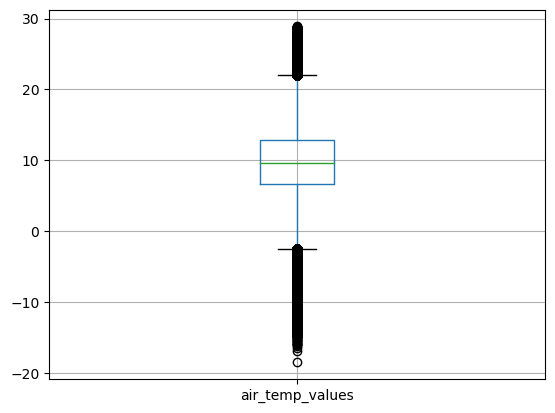

In [33]:
df.boxplot()
plt.show()

## Exercises that extend the notebook
Below are a list of items that could be implemented or changed to the notebook for extended functionality (or issues with the notebook that are "Left As An Exercise To The Reader", sorry!). The list of these items are ordered in my own personal preference for notebook enhancements

- For plots with strange units for time axis, change them to be more appropriate for better understanding
- Try apply the same analysis with different climate data from CEDA

## Data Statement

__Data used in this tutorial uses Met Office UK Climate Projection data__

__Contains public sector information licensed under the Open Government Licence__

- Link to Open Government Licence V3: https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/
- Sources of Data: https://data.ceda.ac.uk/badc/ukcp18/data

______________________________________________________________________

## References

- [Iris](https://scitools-iris.readthedocs.io/en/stable/)
- [NumPy](https://numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [CEDA](https://www.ceda.ac.uk/)
- [Pandas](https://pandas.pydata.org/)
- [UK Climate Projections](https://www.metoffice.gov.uk/research/approach/collaboration/ukcp/about)